In [1]:
import os, sys, glob, argparse
import pandas as pd
import numpy as np
from tqdm import tqdm

import cv2
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

import nibabel as nib
from nibabel.viewers import OrthoSlicer3D

train_path = glob.glob('./脑PET图像分析和疾病预测挑战赛公开数据/Train/*/*')
test_path = glob.glob('./脑PET图像分析和疾病预测挑战赛公开数据/Test/*')

np.random.shuffle(train_path)
np.random.shuffle(test_path)

DATA_CACHE = {}
class XunFeiDataset(Dataset):
    def __init__(self, img_path, transform=None):
        self.img_path = img_path
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None
    
    def __getitem__(self, index):
        if self.img_path[index] in DATA_CACHE:
            img = DATA_CACHE[self.img_path[index]]
        else:
            img = nib.load(self.img_path[index]) 
            img = img.dataobj[:,:,:, 0]
            DATA_CACHE[self.img_path[index]] = img
        
        # 随机选择一些通道            
        idx = np.random.choice(range(img.shape[-1]), 50)
        img = img[:, :, idx]
        img = img.astype(np.float32)

        if self.transform is not None:
            img = self.transform(image = img)['image']
        
        img = img.transpose([2,0,1])
        return img,torch.from_numpy(np.array(int('NC' in self.img_path[index])))
    
    def __len__(self):
        return len(self.img_path)
        
import albumentations as A
train_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_path[:-10],
            A.Compose([
            A.RandomRotate90(),
            A.RandomCrop(120, 120),
            A.HorizontalFlip(p=0.5),
            A.RandomContrast(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
        ])
    ), batch_size=2, shuffle=True, num_workers=1, pin_memory=False
)

val_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_path[-10:],
            A.Compose([
            A.RandomCrop(120, 120),
        ])
    ), batch_size=2, shuffle=False, num_workers=1, pin_memory=False
)

test_loader = torch.utils.data.DataLoader(
    XunFeiDataset(test_path,
            A.Compose([
            A.RandomCrop(128, 128),
            A.HorizontalFlip(p=0.5),
            A.RandomContrast(p=0.5),
        ])
    ), batch_size=2, shuffle=False, num_workers=1, pin_memory=False
)


d:\anaconda1\envs\pytorch\lib\site-packages\albumentations\augmentations\transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [2]:
class XunFeiNet(nn.Module):
    def __init__(self):
        super(XunFeiNet, self).__init__()
                
        model = models.resnet50(True)
        model.conv1 = torch.nn.Conv2d(50, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        model.avgpool = nn.AdaptiveAvgPool2d(1)
        model.fc = nn.Linear(2048, 2)
        self.resnet = model
        
    def forward(self, img):        
        out = self.resnet(img)
        return out
        
model = XunFeiNet()
model = model.to('cuda')
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.AdamW(model.parameters(), 0.001)

d:\anaconda1\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
d:\anaconda1\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


改成ResNet50时，这里要改成model.fc = nn.Linear(2048, 2)#全连接层，而不是512*2。

--------------------------------------
1.学习率（Learning Rate）：学习率是控制模型参数更新步长的关键超参数。可以通过修改 optimizer 的学习率参数来调整学习率。

In [3]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)  # 修改这里的 lr 值

2.批量大小（Batch Size）：批量大小影响每次参数更新的样本数量。增大批量大小可能加速训练，但也可能使模型不稳定。可以在 train_loader 和 val_loader 的 batch_size 参数处修改。

In [4]:
# train_loader = torch.utils.data.DataLoader(
#     XunFeiDataset(np.array(train_path)[train_idx], ...), batch_size=32, ...  # 修改这里的 batch_size 值
# )

3.权重衰减（Weight Decay）：权重衰减可以帮助控制模型的复杂度，防止过拟合。可以在 optimizer 中的 weight_decay 参数处修改。

In [5]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)  # 修改这里的 weight_decay 值

4.训练轮数（Epochs）：增加训练轮数可能有助于模型收敛，但也可能导致过拟合。可以在 range 函数中修改训练的轮数。

In [6]:
# for epoch in range(10):  # 修改这里的轮数，如更改为 10

In [7]:
train_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_path[:-10],
            A.Compose([
            A.RandomRotate90(),
            A.RandomCrop(120, 120),
            A.HorizontalFlip(p=0.5),
            A.RandomContrast(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
        ])
    ), batch_size=2, shuffle=True, num_workers=0, pin_memory=False
)

val_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_path[-10:],
            A.Compose([
            A.RandomCrop(120, 120),
        ])
    ), batch_size=2, shuffle=False, num_workers=0, pin_memory=False
)

test_loader = torch.utils.data.DataLoader(
    XunFeiDataset(test_path,
            A.Compose([
            A.RandomCrop(128, 128),
            A.HorizontalFlip(p=0.5),
            A.RandomContrast(p=0.5),
        ])
    ), batch_size=2, shuffle=False, num_workers=0, pin_memory=False
)

In [8]:
def train(train_loader, model, criterion, optimizer):
    model.train()
    train_loss = 0.0
    for i, (input, target) in enumerate(train_loader):
        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True).long()  # Convert target to LongTensor

        output = model(input)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 20 == 0:
            print(loss.item())

        train_loss += loss.item()

    return train_loss / len(train_loader)

def validate(val_loader, model, criterion):
    model.eval()
    val_acc = 0.0

    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            input = input.cuda()
            target = target.cuda().long()  # Convert target to LongTensor

            output = model(input)
            loss = criterion(output, target)

            val_acc += (output.argmax(1) == target).sum().item()

    return val_acc / len(val_loader.dataset)

In [9]:
import matplotlib.pyplot as plt

train_losses = []   # Store training losses
val_accuracies = [] # Store validation accuracies
train_accuracies = [] # Store training accuracies

from sklearn.metrics import roc_curve, auc

true_labels = []
predicted_probs = []

In [10]:
from sklearn.metrics import f1_score

# Initialize empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

fold_predicted_probs = []
fold_predicted_labels = []

Fold 1/10


d:\anaconda1\envs\pytorch\lib\site-packages\albumentations\augmentations\transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
d:\anaconda1\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
d:\anaconda1\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/3]
0.37619027495384216
0.7573552131652832
Train Loss: 1.2498, Train Acc: 0.4667, Val Acc: 0.4000
Epoch [2/3]
0.762138307094574
1.6586675643920898
Train Loss: 0.7499, Train Acc: 0.4889, Val Acc: 0.6000
Epoch [3/3]
1.5184623003005981
1.091447353363037
Train Loss: 0.8621, Train Acc: 0.4667, Val Acc: 0.2000
Epoch [4/3]
0.5369889736175537
0.7307370901107788
Train Loss: 0.8868, Train Acc: 0.5111, Val Acc: 0.4000
Epoch [5/3]
0.9622751474380493
0.596453070640564
Train Loss: 0.8802, Train Acc: 0.5778, Val Acc: 0.6000
Epoch [6/3]
0.4816373884677887
1.2682163715362549
Train Loss: 0.7447, Train Acc: 0.4222, Val Acc: 0.8000
Epoch [7/3]
0.9996460676193237
0.6656988263130188
Train Loss: 0.7695, Train Acc: 0.5111, Val Acc: 0.4000
Epoch [8/3]
0.7543809413909912
1.0456271171569824
Train Loss: 0.6509, Train Acc: 0.6000, Val Acc: 0.6000
Epoch [9/3]
0.9870085716247559
0.6623969078063965
Train Loss: 0.7493, Train Acc: 0.5111, Val Acc: 0.4000
Epoch [10/3]
0.9523613452911377
0.6482406854629517
Train 

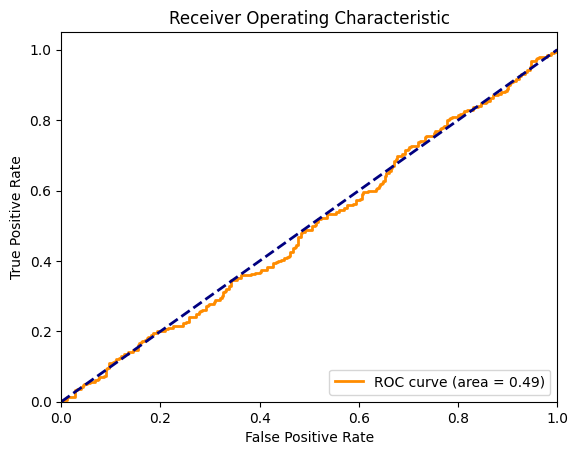

AUC: 0.49244023668639053


ValueError: Found input variables with inconsistent numbers of samples: [650, 600]

In [17]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

skf = StratifiedKFold(n_splits=10, random_state=233, shuffle=True)

labels = [int('NC' in path) for path in train_path]

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train_path, labels)):
    print(f"Fold {fold_idx + 1}/{skf.get_n_splits()}")
    
    train_loader = torch.utils.data.DataLoader(
        XunFeiDataset(np.array(train_path)[train_idx],  # Use np.array to index train_path
            A.Compose([
                A.RandomRotate90(),
                A.RandomCrop(120, 120),
                A.HorizontalFlip(p=0.5),
                A.RandomContrast(p=0.5),
                A.RandomBrightnessContrast(p=0.5),
            ])
        ), batch_size=2, shuffle=True, num_workers=0, pin_memory=False
    )
    
    val_loader = torch.utils.data.DataLoader(
        XunFeiDataset(np.array(train_path)[val_idx],  # Use np.array to index train_path
            A.Compose([
                A.RandomCrop(120, 120),
            ])
        ), batch_size=2, shuffle=False, num_workers=0, pin_memory=False
    )
    
    model = XunFeiNet()
    model = model.to('cuda')
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    
    for epoch in range(3):
        print(f"Epoch [{epoch + 1}/{3}]")
        
        train_loss = train(train_loader, model, criterion, optimizer)
        val_acc = validate(val_loader, model, criterion)
        train_acc = validate(train_loader, model, criterion)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        with torch.no_grad():
            for i, (input, target) in enumerate(val_loader):
                input = input.cuda()
                target = target.cuda().long()

                output = model(input)
                predicted_probs.extend(output.cpu().numpy())
                predicted_labels.extend(output.argmax(1).cpu().numpy())  # Using argmax to get predicted labels
                true_labels.extend(target.cpu().numpy())
        
    # Save the trained model
    model_save_path = f'./resnet50_fold{fold_idx}.pt'
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved at {model_save_path}")

# Convert true labels and predicted probabilities to NumPy arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)
predicted_labels = np.array(predicted_labels)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(true_labels, predicted_probs[:, 1])  # Assuming you have binary classification
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC:", roc_auc)

# 计算F1分数
f1 = f1_score(true_labels, predicted_labels)
print("F1 Score:", f1)



这段代码实现了一个简单的训练和验证循环来训练和评估神经网络模型。以下是代码的主要功能和流程：

1. `train` 函数：
   - 设置模型为训练模式（`model.train()`）。
   - 初始化一个变量 `train_loss` 用于累积每个 batch 的训练损失。
   - 在训练数据加载器上进行循环（`train_loader` 包含训练数据和标签）。
   - 将输入数据和标签转移到 GPU 上（使用 `cuda(non_blocking=True)`）。
   - 将输入数据传递给模型，得到输出。
   - 计算预测输出与真实标签之间的损失，这里使用交叉熵损失函数（`criterion(output, target)`）。
   - 清零优化器的梯度信息（`optimizer.zero_grad()`）。
   - 执行反向传播计算梯度（`loss.backward()`）。
   - 使用优化器更新模型参数（`optimizer.step()`）。
   - 在每个 20 个 batch 后，打印当前 batch 的损失。
   - 累加每个 batch 的损失到 `train_loss` 中。
   - 返回平均训练损失。

2. `validate` 函数：
   - 设置模型为评估模式（`model.eval()`）。
   - 初始化一个变量 `val_acc` 用于累积验证集的预测正确数量。
   - 在验证数据加载器上进行循环（`val_loader` 包含验证数据和标签）。
   - 将输入数据和标签转移到 GPU 上。
   - 将输入数据传递给模型，得到输出。
   - 计算预测输出与真实标签之间的损失。
   - 判断每个样本的预测类别是否与真实类别相符，将匹配的数量累加到 `val_acc` 中。
   - 返回验证集上的准确率（正确预测的样本数除以验证集总样本数）。

3. 主循环：
   - 使用一个循环来重复训练和验证的过程，循环3次（`for _ in range(3):`）。
   - 在每次循环中，首先调用 `train` 函数训练模型并获得训练损失。
   - 然后分别调用 `validate` 函数计算训练集和验证集上的准确率。
   - 最后，打印当前循环中的训练损失、训练集准确率和验证集准确率。

总之，这段代码实现了一个基本的神经网络训练和验证过程，用于训练模型并监控训练和验证的性能。在每次循环中，模型的参数通过优化器进行更新，然后通过计算损失和准确率来监控模型的性能。

------------------------------
根据你提供的代码，我注意到一些潜在的问题。首先，我注意到在数据加载的时候，你将目标标签从 NumPy 数组转换为 PyTorch 张量时，并没有明确地指定数据类型。这可能导致数据类型不匹配的问题。我建议你在这一步明确地指定数据类型为 torch.long，即 LongTensor。另外，你需要将目标标签从原始标签编码（例如 'NC' 或其他类别）转换为整数标签。

------------------------
在你的代码中，你使用了 Windows 系统路径分隔符 \，而在类 Unix 系统中，通常使用 / 作为路径分隔符。因此，当你尝试将类似 Test\98 这样的路径字符串进行切割和转换时，会导致 int() 函数失败，因为其中包含了非数字字符。

为了解决这个问题，你可以考虑使用 Python 的 os.path 模块来处理路径，以确保路径分隔符的一致性。具体做法如下：

In [12]:
def predict(test_loader, model, criterion):
    model.eval()
    val_acc = 0.0
    
    test_pred = []
    with torch.no_grad():
        for i, (input, target) in enumerate(test_loader):
            input = input.cuda()
            target = target.cuda()

            output = model(input)
            test_pred.append(output.data.cpu().numpy())
            
    return np.vstack(test_pred)
    
# Initialize the pred variable
pred = None

# List of model paths
model_paths = ['resnet50_fold0.pt', 'resnet50_fold1.pt', 'resnet50_fold2.pt',
               'resnet50_fold3.pt', 'resnet50_fold4.pt', 'resnet50_fold5.pt',
               'resnet50_fold6.pt', 'resnet50_fold7.pt', 'resnet50_fold8.pt',
               'resnet50_fold9.pt']

# Initialize tqdm for model loop
model_loop = tqdm(model_paths, desc="Models")

for model_path in model_loop:
    model = XunFeiNet()
    model = model.to('cuda')
    model.load_state_dict(torch.load(model_path))
    
    # Initialize tqdm for inference loop
    inference_loop = tqdm(range(10), desc="Inference", leave=False)
    
    for _ in inference_loop:
        if pred is None:
            pred = predict(test_loader, model, criterion)
        else:
            pred += predict(test_loader, model, criterion)
        
        inference_loop.set_postfix({"Avg. Prediction": np.mean(pred)})

# Average the accumulated predictions
pred /= len(model_paths * 10)  # Assuming 10 predictions per model

# Convert predictions to labels
predicted_labels = np.argmax(pred, axis=1)
label_mapping = {1: 'NC', 0: 'MCI'}
predicted_labels = [label_mapping[label] for label in predicted_labels]

# Create a submission DataFrame
submit = pd.DataFrame({
    'uuid': [int(x.split('\\')[-1][:-4]) for x in test_path],
    'label': predicted_labels
})

# Sort the DataFrame by 'uuid'
submit = submit.sort_values(by='uuid')

# Save the submission CSV
submit.to_csv('submit2_cv_res50_1.csv', index=None)


Models:   0%|          | 0/10 [00:00<?, ?it/s]d:\anaconda1\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
d:\anaconda1\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Models: 100%|██████████| 10/10 [09:12<00:00, 55.25s/it]


权重可视化： 可以查看卷积层的权重，了解模型学到的特征。

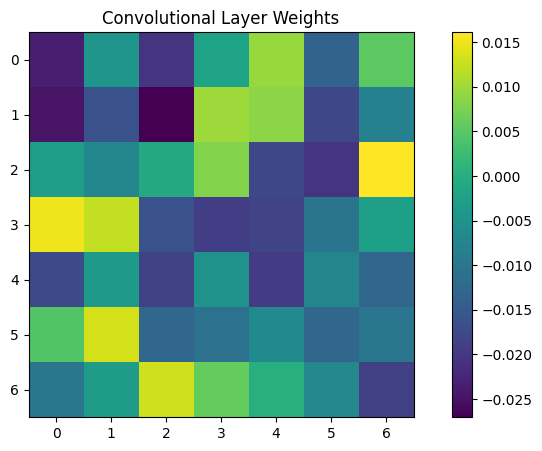

In [13]:
import matplotlib.pyplot as plt

def plot_weights(layer):
    weights = layer.weight.data.cpu().numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(weights[0, 0], cmap='viridis')
    plt.colorbar()
    plt.title("Convolutional Layer Weights")
    plt.show()

# Example usage
conv_layer = model.resnet.conv1  # Get a convolutional layer from your model
plot_weights(conv_layer)


模型架构可视化

In [14]:
from torchsummary import summary

summary(model, input_size=(50, 7, 7))  # Adjust input_size according to your model's input shape


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 4, 4]         156,800
       BatchNorm2d-2             [-1, 64, 4, 4]             128
              ReLU-3             [-1, 64, 4, 4]               0
         MaxPool2d-4             [-1, 64, 2, 2]               0
            Conv2d-5             [-1, 64, 2, 2]           4,096
       BatchNorm2d-6             [-1, 64, 2, 2]             128
              ReLU-7             [-1, 64, 2, 2]               0
            Conv2d-8             [-1, 64, 2, 2]          36,864
       BatchNorm2d-9             [-1, 64, 2, 2]             128
             ReLU-10             [-1, 64, 2, 2]               0
           Conv2d-11            [-1, 256, 2, 2]          16,384
      BatchNorm2d-12            [-1, 256, 2, 2]             512
           Conv2d-13            [-1, 256, 2, 2]          16,384
      BatchNorm2d-14            [-1, 25

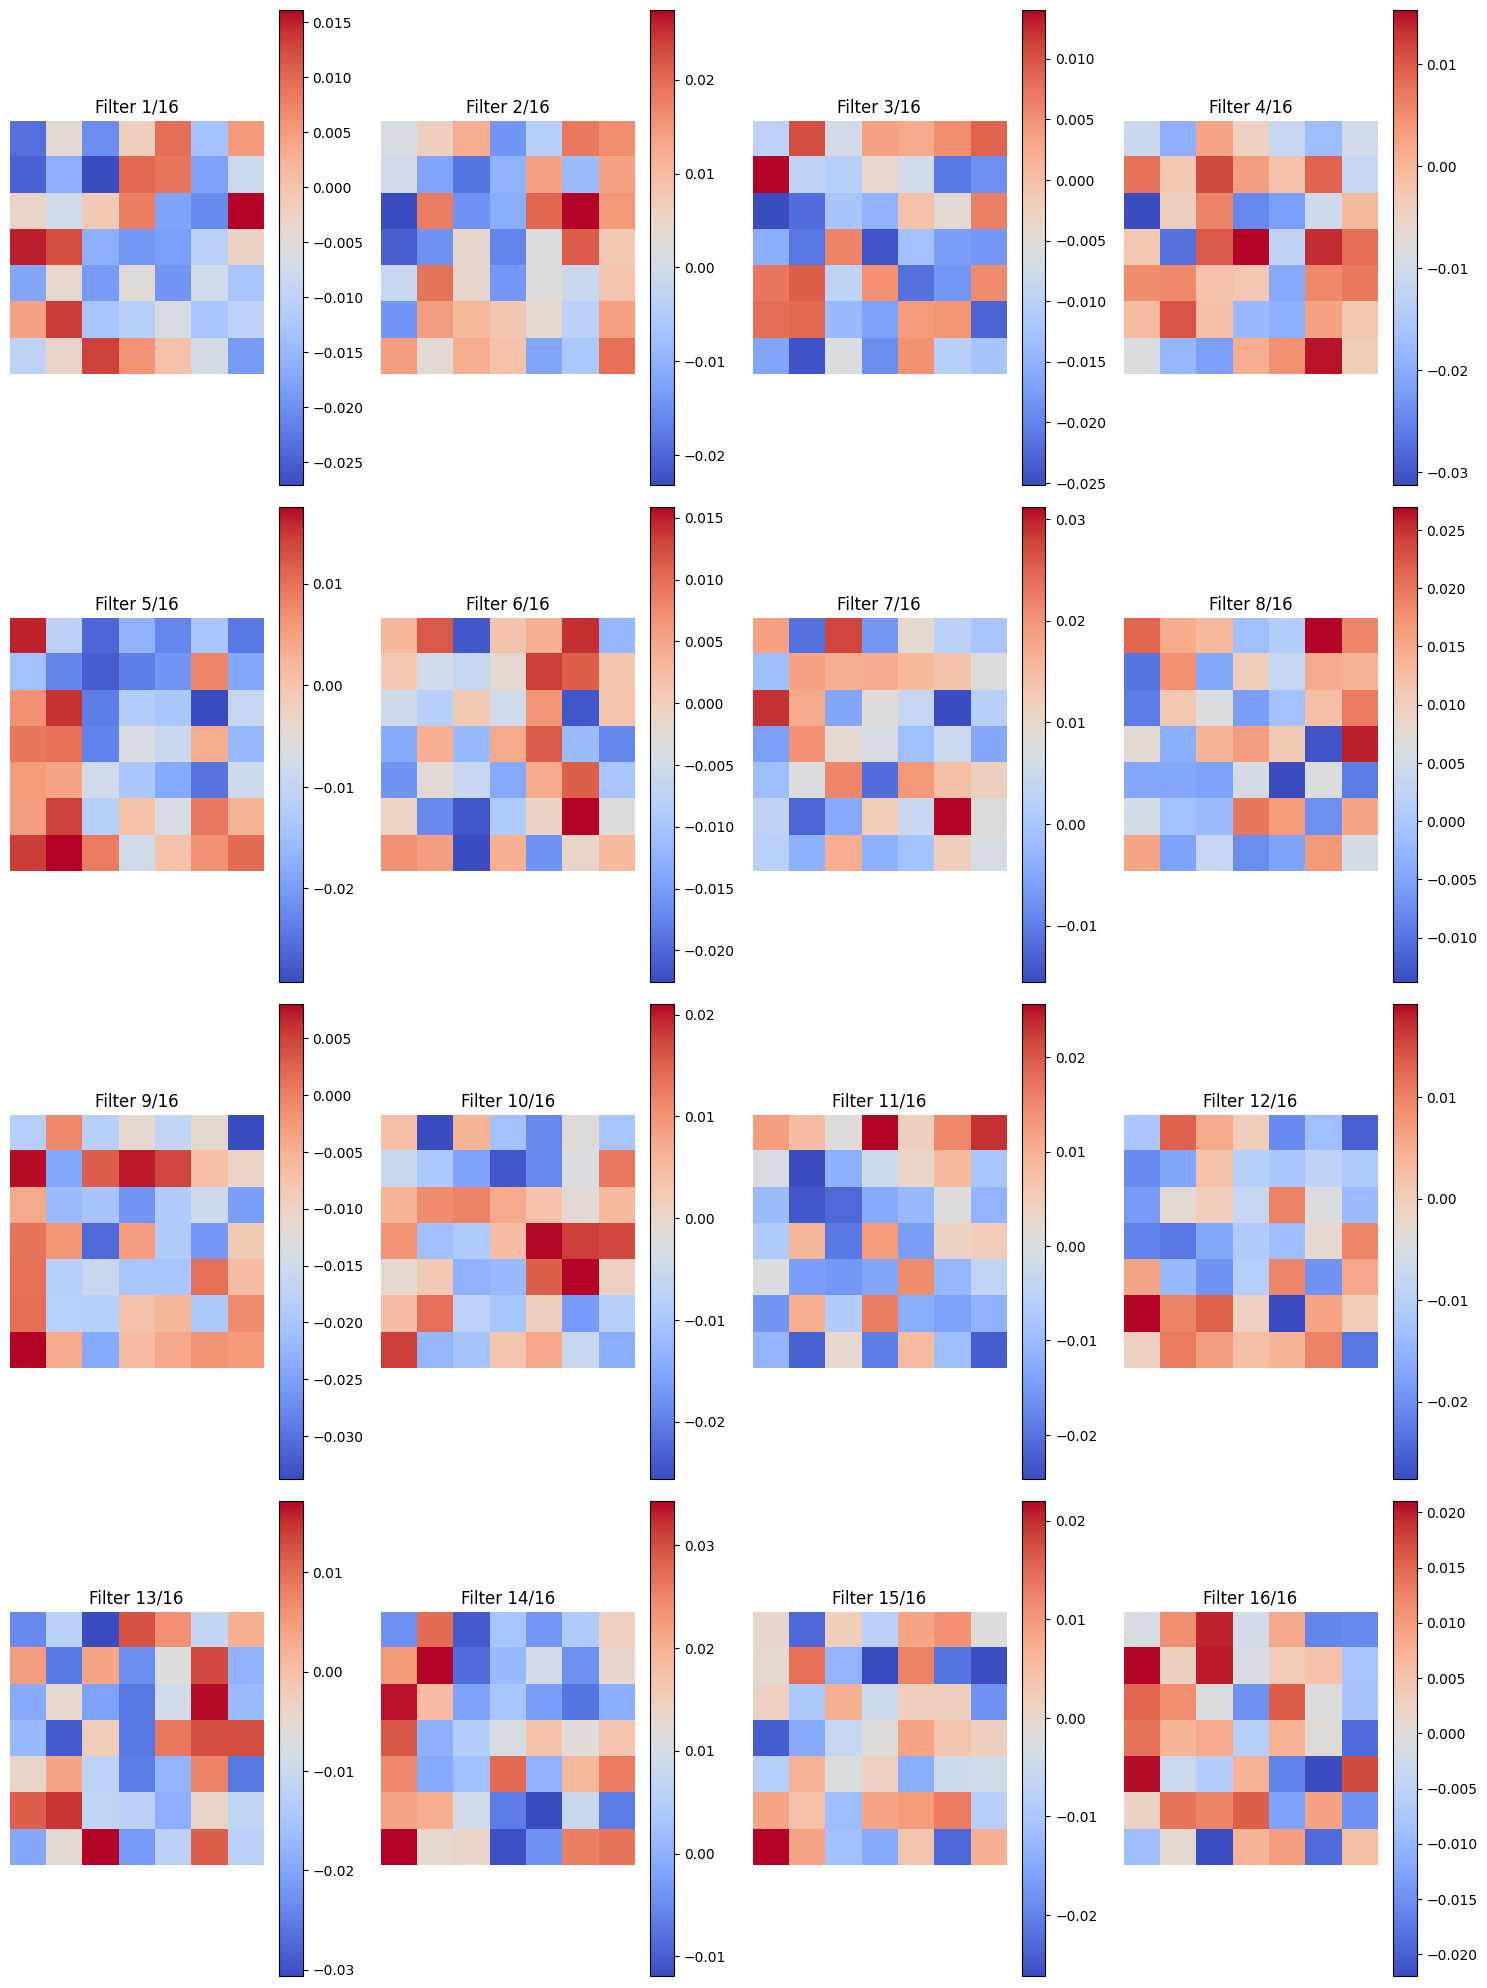

In [15]:
import matplotlib.pyplot as plt

def plot_weights(layer, num_filters=16):
    weights = layer.weight.data.cpu().numpy()
    num_channels = weights.shape[1]

    # Determine the number of rows and columns for subplots
    cols = min(num_filters, 4)
    rows = (num_filters + cols - 1) // cols

    plt.figure(figsize=(15, 5 * rows))
    
    for i in range(num_filters):
        plt.subplot(rows, cols, i + 1)
        
        # Choose a colormap that provides good contrast
        plt.imshow(weights[i, 0], cmap='coolwarm', interpolation='nearest')
        plt.colorbar()
        
        plt.title(f"Filter {i + 1}/{num_filters}")
        
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
conv_layer = model.resnet.conv1  # Get a convolutional layer from your model
plot_weights(conv_layer)


用了ResNet50后依然是全NC?

------------------------------------
换了ResNet50后仍然没有明显改进